In [216]:
import pandas;
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import OneHotEncoder, StandardScaler;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization;
from tensorflow.keras.regularizers import l2, l1_l2;
from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;
from tensorflow.keras.optimizers import Adam;
import matplotlib.pyplot as plt;
import numpy;


In [217]:
dataframe = pandas.read_csv("loan_data.csv");

dataframe.head()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


# Data Initialization

THis step pre-process the whole data by encode the data as step below:

1. Drop na
2. Binary Encode Gender, Self_Employed, Married, Education, and Loan_Status
3. Define whole_feature by disclude Loan_ID, and Loan_Status
4. Define whole_label by including only Loan_Status

Drop Loan_ID and Loan_Status for the whole_feature

In [218]:
dataframe = dataframe.dropna();
dataframe = dataframe.replace({
    "Gender": {"Male":1,"Female" :0},
    "Self_Employed": {"Yes": 1, "No": 0},
    "Married": {"Yes": 1, "No": 0}, 
    "Education": {"Graduate": 1, "Not Graduate": 0}, 
    "Loan_Status": {"Y": 1, "N": 0}
});


whole_feature = dataframe.drop(columns = ["Loan_ID", "Loan_Status"]);
whole_label = dataframe["Loan_Status"];

feature_train, feature_test, label_train, label_test = train_test_split(whole_feature, whole_label, train_size = 0.7, test_size = 0.3, random_state = 42);
feature_test, feature_val, label_test, label_val =train_test_split(feature_test, label_test, train_size = 0.5, test_size = 0.5, random_state = 42);

feature_train.shape, feature_test.shape, feature_val.shape, label_train.shape, label_test.shape, label_val.shape

((215, 11), (46, 11), (47, 11), (215,), (46,), (47,))

# Data Pre-Processing

1. Perform One-Hot Encoding to Property area and Dependents
2. Standard Scaler all features

In [219]:
encoder = OneHotEncoder();
columns_to_be_encoded = ["Property_Area", "Dependents"];
encoder.fit(feature_train[columns_to_be_encoded]);

for i, e in enumerate([feature_train, feature_test, feature_val]):

    # Encode the train data first
    encoded_property_area = pandas.DataFrame(
        encoder.transform(e[columns_to_be_encoded]).toarray(),
        columns = encoder.get_feature_names_out()
    );

    e = e.reset_index();
    e = pandas.concat([e, encoded_property_area], axis = 1);

    # Drop the original Property_Area column
    e = e.drop(columns = columns_to_be_encoded);

    if(i == 0):
        feature_train = e;
    elif(i == 1):
        feature_test = e;
    else:
        feature_val = e;


feature_train.head()

,index,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_0,Dependents_1,Dependents_2,Dependents_3+
0,368,1,1,1,0,2297,1522.0,104.0,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,356,1,1,1,0,3400,2500.0,123.0,360.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,89,1,1,1,0,2698,2034.0,122.0,360.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,19,1,0,0,0,1442,0.0,35.0,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,12,1,1,0,0,4887,0.0,133.0,360.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [220]:
# Call out Step 2
scaler = StandardScaler();

feature_train = scaler.fit_transform(feature_train);
feature_test = scaler.fit_transform(feature_test);
feature_val = scaler.fit_transform(feature_val);


# Pre-Training data setup

This section will setup all data into float32 numpy array

In [221]:
feature_train = numpy.array(feature_train, dtype = numpy.float32);
feature_test = numpy.array(feature_test, dtype = numpy.float32);
feature_val = numpy.array(feature_val, dtype = numpy.float32);
label_train = numpy.array(label_train, dtype = numpy.float32);
label_test = numpy.array(label_test, dtype = numpy.float32);
label_val = numpy.array(label_val, dtype = numpy.float32);

# Model Architecture

In [255]:
class ANNModel():
    def __init__(self):
        self.input = InputLayer(input_shape = (17,)); # Total input layer is 17

        # Hidden Layer 1
        self.dense1 = Dense(256, kernel_initializer = "glorot_uniform", kernel_regularizer = l2(1e-4));
        self.bn1 = BatchNormalization();
        self.dropout1 = Dropout(0.5);

        self.dense2 = Dense(256, kernel_initializer = "glorot_uniform", kernel_regularizer = l2(1e-2));
        self.bn2 = BatchNormalization();
        self.dropout2 = Dropout(0.5);


        self.output = Dense(1, activation = "sigmoid", kernel_initializer = "glorot_uniform");
    
    # Early stopping after loss are not improved for some epochs
    def _callback_early_stopping(self):
        early_stopping_tolerance = 500;

        return EarlyStopping(
            monitor = "val_loss",
            patience = early_stopping_tolerance,
            restore_best_weights = True
        );

    def forward(self):
        model = Sequential();
        
        # Construct the model
        model.add(self.input);

        model.add(self.dense1);
        model.add(self.dropout1);
        model.add(self.bn1);

        model.add(self.dense2);
        model.add(self.dropout2);
        model.add(self.bn2);

        model.add(self.output);

        plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);
        model.summary();
        self.model = model;

    def fitting(self):
        self.forward();

        model = self.model;

        optimization = Adam(learning_rate = 1e-3);
        
        model.compile(loss = "binary_crossentropy", optimizer = optimization, metrics = "binary_accuracy");

        history = model.fit(
            feature_train, 
            label_train, 
            epochs = 10000, 
            validation_data = (feature_val, label_val), 
            batch_size = 32,
            callbacks = [self._callback_early_stopping()]
        );

        plt.plot(history.history["loss"], label = "Model Training Loss");
        plt.plot(history.history["val_loss"], label = "Model Validation Loss");
        plt.plot(history.history["val_binary_accuracy"], label = "Model Validation Accuracy (binary_accuracy)");
        plt.title("Training and Validation Loss & Accuracy");
        plt.xlabel("Epochs");
        plt.ylabel("Loss (binary_crossentropy)");
        plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5));
        plt.show();

        return model;

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_346 (Dense)           (None, 256)               4608      
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_28 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_347 (Dense)           (None, 256)               65792     
                                                                 
 dropout_59 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_29 (Bat  (None, 256)              1024      
 chNormalization)                                    

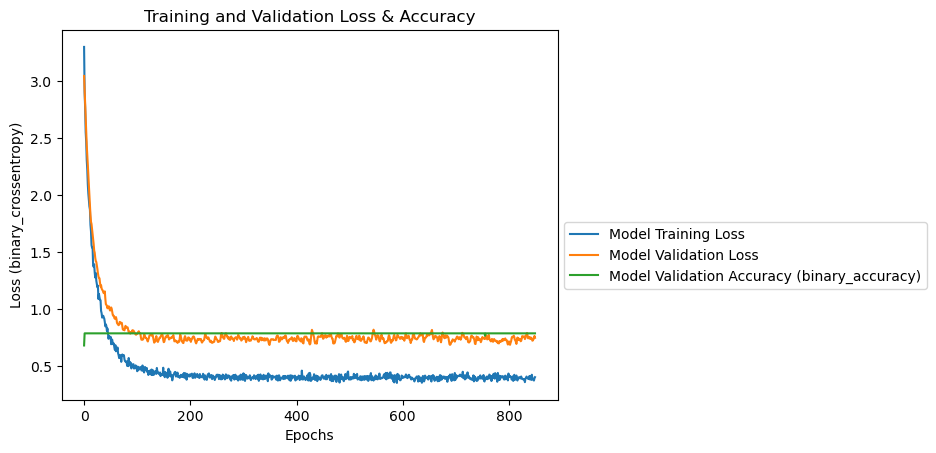

2/2 [==============================] - 0s 3ms/step - loss: 0.5018 - binary_accuracy: 0.8043
Loss:  0.5018293857574463  Accuracy:  0.804347813129425


In [256]:
ann = ANNModel();

model = ann.fitting();

loss, accuracy = model.evaluate(feature_test, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);